In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate, train_test_split
import mat4py
from sklearn import metrics
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data
import models
import pickle as pkl
from style import *
import viz
import copy
import trend_filtering
from tqdm import tqdm
import train

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
df = data.get_data(use_processed=True) # all_data=True
outcome = 'y_consec_thresh'

In [4]:
df_tf = copy.deepcopy(df)
for i in range(len(df)):
    df_tf['X'].iloc[i] = trend_filtering.trend_filtering(y=df['X'].iloc[i], vlambda=500, order=1) 
df_tf = data.preprocess(df_tf)

In [5]:
feat_names = data.get_feature_names(df_tf)

# don't use dict_feats
feat_names = [x for x in feat_names 
              if not x.startswith('sc_') 
              and not x.startswith('nmf_')
              and not x in ['center_max', 'left_max', 'right_max', 'up_max', 'down_max', 
                            'X_max_around_Y_peak', 'X_max_after_Y_peak', 'X_max_diff_after_Y_peak',
                           'X_tf']
              and not x.startswith('pc_')
#               and not 'local' in x
#               and not 'X_peak' in x
#               and not 'slope' in x
#               and not x in ['fall_final', 'fall_slope', 'fall_imp', 'fall']
             ]

In [14]:
outcome_def = 'y_consec_thresh'
# out_dir = f'results/outcome={outcome_def}'
out_dir = oj('/scratch/users/vision/abc', 'mar7_tf_order_1')
os.makedirs(out_dir, exist_ok=True)
feature_selection_nums = [5] #[3, 5, 7, 12, 16]: # number of feature to select [4, 9, 11, 23, 35, 39]
for feature_selection_num in feature_selection_nums:
    for feature_selection in [None]: # select_lasso, select_rf, None
        if feature_selection is None and feature_selection_num > feature_selection_nums[0]: # don't do extra computation
            break
        for model_type in tqdm(['rf', 'svm', 'mlp2']): #,'gb', 'logistic', 'dt', 'svm', 'gb', 'rf', 'mlp2', 'irf']):
            for num_feats in [12, 16, 25, len(feat_names)]: #[16, 25, len(feat_names)]: # number of total features to consider
                for balancing in ['ros']: # None, ros                        
                    for balancing_ratio in [1.2]: # positive: negative  
                        hyperparams = [0]
                        for hyperparam in hyperparams: # 0 is default
                            feats = feat_names[:num_feats]
                            out_name = f'{model_type}_{num_feats}_{feature_selection}={feature_selection_num}_{balancing}={balancing_ratio}_h={hyperparam}'
                            train.train(df_tf, feat_names=feats, model_type=model_type, 
                                        balancing=balancing, balancing_ratio=balancing_ratio,
                                        outcome_def=outcome_def,
                                        feature_selection=feature_selection,
                                        feature_selection_num=feature_selection_num,
                                        hyperparam=hyperparam,
                                        out_name=f'{out_dir}/{out_name}.pkl')

100%|██████████| 3/3 [01:26<00:00, 23.99s/it]


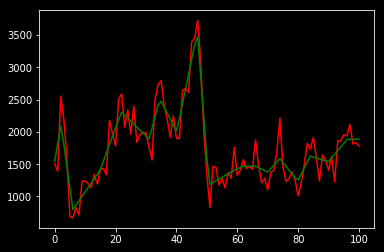

In [15]:
plt.plot(df['X'].iloc[0], color='red')
plt.plot(df_tf['X'].iloc[0], color='green')